In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import timedelta, datetime

aims:
1. extract features from test failing vehicles
2. build classification model for predicting outcome of emission test for vehicles


# import data
[here](https://opendata.cabq.gov/dataset/vehicle-emissions/resource/2663c138-549e-4d55-932f-6aa549c7d158) is the MetaData


In [3]:
df_all = pd.read_csv('data/sample201320.csv', low_memory=False)

print("data size:", df_all.shape)
df_all.head(2)


data size: (193310, 127)


,RecordID,RECORD_NUM,VIR_CERT_NUMBER,STATION_NUM,ANALYZER_NUM,INSPECTOR_NUM,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,VIN_SOURCE,VEH_LICENSE,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,ESC,VRT_RECORD_ID,E_TEST_SEQUENCE,E_PRECOND_PROCEDURE,E_HIGH_DCF,E_HIGH_RPM,E_HIGH_CO2,E_HIGH_O2,E_HIGH_HC,E_HIGH_HC_DCF,E_HIGH_HC_LIMIT,E_HIGH_CO,E_HIGH_CO_DCF,E_HIGH_CO_LIMIT,E_IDLE_DCF,E_IDLE_RPM,E_IDLE_CO2,E_IDLE_O2,E_IDLE_HC,E_IDLE_HC_DCF,E_IDLE_HC_LIMIT,E_IDLE_CO,E_IDLE_CO_DCF,E_IDLE_CO_LIMIT,E_HIGH_DCF_2,E_HIGH_RPM_2,E_HIGH_CO2_2,E_HIGH_O2_2,E_HIGH_HC_2,E_HIGH_HC_DCF_2,E_HIGH_CO_2,E_HIGH_CO_DCF_2,E_IDLE_DCF_2,E_IDLE_RPM_2,E_IDLE_CO2_2,E_IDLE_O2_2,E_IDLE_HC_2,E_IDLE_HC_DCF_2,E_IDLE_CO_2,E_IDLE_CO_DCF_2,E_RESULT_STRING,V_SMOKE1,V_SMOKE2,V_GASCAP,V_CAT,V_RESULT,KOEO_RESULT,KOER_RESULT,OBD_RDY_MISFIRE,OBD_RDY_FUEL,OBD_RDY_COMPONENT,OBD_RDY_CAT,OBD_RDY_CAT_HEATED,OBD_RDY_EVAP,OBD_RDY_SEC_AIR,OBD_RDY_AIR_COND,OBD_RDY_O2_SENSOR,OBD_RDY_O2_HEATER,OBD_RDY_EGR,OBD_RDY_RESULT,OBD_PID,OBD_PCM_ID,OBD_VIN,OBD_FLT_CODES,OBD_FLT_RESULT,OBD_MIL_STATUS,OBD_RESULT,ONLINE_STATUS,OFFLINE_REASON_CODE,ABORT_CODE,SOFTWARE_VERSION,INSP_COMMENTS,OVERALL_RESULT,R_TOTAL_COST,R_EGR,R_ELECTRICAL,R_EVAP_CONTROL,R_EXHAUST,R_IGNITION,R_INTAKE,R_ENGINE,R_PCV,R_OTHER,SentToWW,ABORT_CODE_OTHER_DESC,OBDII_AFFECT_OVERALL,E_HIGH_CO_RESULT,E_HIGH_HC_RESULT,E_IDLE_CO_RESULT,E_IDLE_HC_RESULT,MECHANIC_LAST_NAME,MECHANIC_FIRST_NAME,MECHANIC_MIDDLE_INIT,ENGINE_SIZE_ORIG,FAILED_IDLE_RPM,SENTTOVID,Station_License_Number,Analyzer_Number,Insert_DateTime
0,2690332,10433,6878785.0,IS311,W028,AC084149,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,S,368RBP,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.0,87121,C,6.0,20050189,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,P,P,P,P,P,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,P,19.0,10,1G4HP52K45U160372,NaN,P,1.0,P,0,0,NaN,502,NaN,P,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,0,NaN,N,N,N,N,N,Huber,Bryan,S,NaN,NaN,0,IS311,W028,2013-03-04 16:26:26
1,2804644,18225,6979071.0,IR317,W039,37826481,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,S,843NWS,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.0,87108,C,6.0,0,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,N,P,P,P,P,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,P,38.0,E8,3VWSF71K66M706988,NaN,P,1.0,P,1,0,NaN,502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,NGUYEN,HANH,A,2.5L,NaN,0,IR317,W039,2013-07-22 17:41:06


# target


Num of rows with missing values: 0


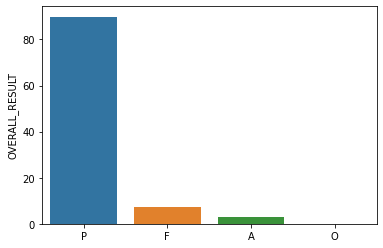

In [4]:
import seaborn as sns
y = df_all['OVERALL_RESULT']
print('Num of rows with missing values:', y.isnull().sum())
tmp = y.value_counts()*100.0/y.shape[0]
sns.barplot(x=tmp.index, y=tmp);

In [5]:
y.value_counts()

P    173762
F     13741
A      5805
O         2
Name: OVERALL_RESULT, dtype: int64

In [6]:
df_all.loc[(df_all.OVERALL_RESULT=='A') & (df_all.ABORT_CODE_OTHER_DESC.notnull()), 'ABORT_CODE_OTHER_DESC'].head(30)

129                               vin wrong
524                    Test Time Expiration
564                       wrong action used
610                             wrong plate
766                    Test Time Expiration
826                    Test Time Expiration
994                              wrong info
1059              WILL NOT PICK UP OBD INFO
1119                   DIDNT NEED EMISSIONS
1147                             wrong info
1472                             wrong year
1802                            wrong plage
1862                   Test Time Expiration
1930                              WRONG CAR
1942              wrong engine size entered
2225                   Test Time Expiration
2283                            wrong plate
2377                               car info
2571                         11000 LBS GVWR
2985                             WRONG INFO
3040                           not required
3137                            WRONG MODEL
3143                            

In [7]:
# drop the rows where the test was aborted
df_all = df_all[~df_all.OVERALL_RESULT.isin(['A','O'])]
df_all.OVERALL_RESULT.value_counts()

P    173762
F     13741
Name: OVERALL_RESULT, dtype: int64

# vehicle features


In [8]:
# find the unique id column
print(df_all.shape[0])
print(df_all[['RecordID', 'RECORD_NUM', 'VIR_CERT_NUMBER']].nunique())

187503
RecordID           187503
RECORD_NUM          31005
VIR_CERT_NUMBER    187312
dtype: int64


In [9]:
# set RecordID as index
df_all.set_index('RecordID', inplace=True)
print("RecordID has been set as index")

RecordID has been set as index


## vehicle features - cleaning


1. select the columns that belongs to vehicle features and target column


2. transform datetime columns


    - if a vehicle has multiple records from the same date, keep latest record
    
        - Number of records where vehicles got tested more than 1 time a day: 4047
        - Number of records after removing repeated tests from same day: 183456 
        
    - extract month, week, weekday ?? testing time ~ testing outcome??   
    
    
        
3. transformed the categorical columns to numeric


4. changed object type columns to string and MODEL_YEAR to string



### select columns


In [10]:
# select the columns related to vehicle features
vehicle_cols = ['OVERALL_RESULT', 
                 'VIN', 'VIN_SOURCE', 'VEH_LICENSE', 'VRT_RECORD_ID',
                 'GVW_TYPE', 'GVWR', 
                 'MODEL_YEAR', 'MAKE', 'MODEL', 
                 'CYL', 'ENGINE_SIZE', 'TRANS_TYPE', 
                 'DUAL_EXHAUST', 
                 'ODOMETER', 'FUEL_TYPE', 'VEHICLE_TYPE', 
                 'EMISS_COST', 
                 'ZIP_CODE', 'CERTIFICATION',
                 'TEST_TYPE', 'VID_TEST_TYPE', 
                 'TEST_SDATE', 'TEST_EDATE']
df = df_all[vehicle_cols].copy()
df.head(2)

,OVERALL_RESULT,VIN,VIN_SOURCE,VEH_LICENSE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
2690332,P,1G4HP52K45U160372,S,368RBP,20050189,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.0,87121,C,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,P,3VWSF71K66M706988,S,843NWS,0,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.0,87108,C,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00


In [11]:
# check data types
df.dtypes.sort_values()

ENGINE_SIZE         int64
VRT_RECORD_ID       int64
GVWR                int64
MODEL_YEAR          int64
VEHICLE_TYPE        int64
ODOMETER            int64
GVW_TYPE          float64
EMISS_COST        float64
VID_TEST_TYPE      object
TEST_TYPE          object
CERTIFICATION      object
ZIP_CODE           object
FUEL_TYPE          object
OVERALL_RESULT     object
TRANS_TYPE         object
TEST_SDATE         object
CYL                object
MODEL              object
MAKE               object
VEH_LICENSE        object
VIN_SOURCE         object
VIN                object
DUAL_EXHAUST       object
TEST_EDATE         object
dtype: object

### dates


In [12]:
# select date columns
date_cols = ['TEST_SDATE', 'TEST_EDATE']

# transform date columns
def to_datetime(df, date_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    return df

df = to_datetime(df, date_cols)
print(df[date_cols].dtypes)
df[date_cols].head()

TEST_SDATE    datetime64[ns]
TEST_EDATE    datetime64[ns]
dtype: object


,TEST_SDATE,TEST_EDATE
RecordID,,
2690332,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,2013-07-22 16:55:00,2013-07-22 16:56:00
2779074,2013-06-18 12:45:00,2013-06-18 12:47:00
2761810,2013-05-29 16:17:00,2013-05-29 16:18:00
2733004,2013-04-22 15:54:00,2013-04-22 15:58:00


**⚠️ if a vehicle has multiple records from the same date, keep latest record**

In [13]:
# add a helper column which has date but not hours of the day
df['TEST_DATE'] = df['TEST_EDATE'].dt.date

# keep the lastest record from the same date for each vehicle
df1 = df.loc[df.groupby(['VIN', 'TEST_DATE'])['TEST_EDATE'].idxmax(),:].copy()

# select the records whose vehicles got tested more than 1 time a day, can capture some extra information here
df2 = df[~df.index.isin(df1.index)]
print("Number of records where vehicles got tested more than 1 time a day:", df2.shape[0])
print("Number of records after removing repeated tests from same day:", df1.shape[0])

# save df1 as df and drop the helper column
df = df1.drop(columns=['TEST_DATE'])

Number of records where vehicles got tested more than 1 time a day: 4047
Number of records after removing repeated tests from same day: 183456


### categorical columns 

In [14]:
# choose categorical columns
df.select_dtypes(exclude='number').nunique().sort_values(ascending=True)[:10]

OVERALL_RESULT     2
VIN_SOURCE         2
TRANS_TYPE         2
DUAL_EXHAUST       2
TEST_TYPE          2
VID_TEST_TYPE      2
CERTIFICATION      5
FUEL_TYPE          7
CYL               10
MAKE              92
dtype: int64

In [15]:
# select the categorical columns
categorical_cols = df.select_dtypes(exclude='number').nunique().sort_values(ascending=True).index[:9]

print('Before factorizing')
df[categorical_cols].head()

Before factorizing


,OVERALL_RESULT,VIN_SOURCE,TRANS_TYPE,DUAL_EXHAUST,TEST_TYPE,VID_TEST_TYPE,CERTIFICATION,FUEL_TYPE,CYL
RecordID,,,,,,,,,
4118828,F,S,A,N,I,NaN,F,G,4
3716231,P,S,A,N,I,I,C,D,4
2643540,P,S,A,N,I,I,C,G,6
3870644,P,M,A,N,I,I,C,G,8
3951493,P,M,A,N,I,I,C,G,4


In [16]:
# define a function for transforming the categorical columns to numeric
def factorize(df, cols):
    for col in cols:
        df[col] = pd.factorize(df[col])[0]
        df[col].replace({-1: np.nan}, inplace=True)
    return df

# apply the function
df = factorize(df, categorical_cols)

print('After factorizing')
df[categorical_cols].head()

After factorizing


,OVERALL_RESULT,VIN_SOURCE,TRANS_TYPE,DUAL_EXHAUST,TEST_TYPE,VID_TEST_TYPE,CERTIFICATION,FUEL_TYPE,CYL
RecordID,,,,,,,,,
4118828,0,0,0,0,0,NaN,0,0,0
3716231,1,0,0,0,0,0.0,1,1,0
2643540,1,0,0,0,0,0.0,1,0,1
3870644,1,1,0,0,0,0.0,1,0,2
3951493,1,1,0,0,0,0.0,1,0,0


### strings

In [17]:
df.select_dtypes(exclude=['number', 'datetime']).head(2)

,VIN,VEH_LICENSE,MAKE,MODEL,ZIP_CODE
RecordID,,,,,
4118828,0BBSK5468MZ014126,389NCH,GEO,PRIZM,87047
3716231,0S2RC61H045251900,NP251900,SUZUKI,AERIO,87123


In [18]:
# select string columns

string_cols = ['VIN', 'VEH_LICENSE', 'MAKE', 'MODEL', 'ZIP_CODE', 'MODEL_YEAR']

# tranform string columns

def to_string(df, string_cols):
    for col in string_cols:
        df[col] = df[col].astype('string').str.strip().str.lower()
        df
    return df

df = to_string(df, string_cols)
print(df[string_cols].dtypes)
df[string_cols].head()

VIN            string
VEH_LICENSE    string
MAKE           string
MODEL          string
ZIP_CODE       string
MODEL_YEAR     string
dtype: object


,VIN,VEH_LICENSE,MAKE,MODEL,ZIP_CODE,MODEL_YEAR
RecordID,,,,,,
4118828,0bbsk5468mz014126,389nch,geo,prizm,87047,1991
3716231,0s2rc61h045251900,np251900,suzuki,aerio,87123,2004
2643540,0t3hn86r919053130,lpf775,toyota,4runner 4wd,87108,2001
3870644,107ha182x6j111384,661tcb,dodge,ram 1500 2wd,87105,2006
3951493,124al2ap0an440796,np440796,nissan,altima,87110,2010


### numeric columns


In [19]:
# numeric columns
df.select_dtypes(include='number').head()

,OVERALL_RESULT,VIN_SOURCE,VRT_RECORD_ID,GVW_TYPE,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE
RecordID,,,,,,,,,,,,,,,,
4118828,0,0,910511,1.0,2625,0,1600,0,0,215161,0,1,16.12,0,0,NaN
3716231,1,0,20040476,1.0,3000,0,2300,0,0,156888,1,1,15.00,1,0,0.0
2643540,1,0,20010500,1.0,4250,1,3400,0,0,124227,0,4,16.00,1,0,0.0
3870644,1,1,0,1.0,6000,2,5700,0,0,66315,0,3,25.00,1,0,0.0
3951493,1,1,0,1.0,3375,0,2500,0,0,112471,0,1,18.00,1,0,0.0


## vehicle features - feature engineering


1. VEHICLE_AGE = (TEST_SDATE.dt.year - MODEL_YEAR)

2. MAKE_MODEL

3. YEAR_MODEL

4. ZIP_CODE ???

In [20]:
# engineering VEHICLE_AGE
df['VEHICLE_AGE'] = df.TEST_SDATE.dt.year.astype('int') - df.MODEL_YEAR.astype('int')

# when MODEL_YEAR=0, replace the value in VEHICLE_AGE to np.nan
df.loc[df.MODEL_YEAR == '0', 'VEHICLE_AGE'] = np.nan

In [21]:
# make + model
df['MAKE_MODEL'] = df.MAKE + '/' + df.MODEL
print("number of unique MAKE_MODEL:", df.MAKE_MODEL.nunique())

# model + year
df['YEAR_MODEL'] = df.MODEL_YEAR + '/' + df.MODEL
print("number of unique YEAR_MODEL:", df.YEAR_MODEL.nunique())
print("number of total records:", df.shape[0])

number of unique MAKE_MODEL: 2764
number of unique YEAR_MODEL: 11318
number of total records: 183456


In [22]:
# ZIP_CODE ???
# New Mexico ABQ zipcodes start with 871
tmp = df.ZIP_CODE.str[:3]
print("Number of records with zipcodes belong to ABQ:", tmp[tmp=='871'].shape[0])

Number of records with zipcodes belong to ABQ: 177855


## vehicle features - exploration


1. general exploration


2. vehicles with historical records

Notes:
- a model/make could have many different names or there might be some typos
- 


### general


In [23]:
# seems we don't really need the following columns let's drop them
cols_to_drop = ['VIN_SOURCE', 'VEH_LICENSE', 'VRT_RECORD_ID']
df = df.drop(columns=cols_to_drop)

df.shape

(183456, 24)

In [24]:
df.head()

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
4118828,0,0bbsk5468mz014126,1.0,2625,1991,geo,prizm,0,1600,0,0,215161,0,1,16.12,87047,0,0,NaN,2018-04-11 13:54:28,2018-04-11 14:01:45,27.0,geo/prizm,1991/prizm
3716231,1,0s2rc61h045251900,1.0,3000,2004,suzuki,aerio,0,2300,0,0,156888,1,1,15.00,87123,1,0,0.0,2016-10-15 15:09:00,2016-10-15 15:13:00,12.0,suzuki/aerio,2004/aerio
2643540,1,0t3hn86r919053130,1.0,4250,2001,toyota,4runner 4wd,1,3400,0,0,124227,0,4,16.00,87108,1,0,0.0,2013-01-03 16:45:00,2013-01-03 16:47:00,12.0,toyota/4runner 4wd,2001/4runner 4wd
3870644,1,107ha182x6j111384,1.0,6000,2006,dodge,ram 1500 2wd,2,5700,0,0,66315,0,3,25.00,87105,1,0,0.0,2017-05-13 14:56:00,2017-05-13 14:57:00,11.0,dodge/ram 1500 2wd,2006/ram 1500 2wd
3951493,1,124al2ap0an440796,1.0,3375,2010,nissan,altima,0,2500,0,0,112471,0,1,18.00,87110,1,0,0.0,2017-08-24 17:59:00,2017-08-24 18:04:00,7.0,nissan/altima,2010/altima


In [25]:
df.dtypes.value_counts()

int64             11
string             7
float64            4
datetime64[ns]     2
dtype: int64

In [26]:
# range of dates 
print('Date range', min(df['TEST_SDATE']),  max(df['TEST_EDATE']))

Date range 2013-01-01 14:10:00 2020-12-31 17:40:36


In [27]:
# data quality control, check whether some rows have SDATE later then EDATE
df[df['TEST_EDATE'] < df['TEST_SDATE']]

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
3726458,1,5tfdv54158x032920,2.0,6400,2008,toyota,tundra 4wd,2,5700,0,0,171208,0,3,20.0,87121,1,0,0.0,2016-10-31 08:43:00,2016-10-31 07:45:00,8.0,toyota/tundra 4wd,2008/tundra 4wd
3399779,1,knafe121965348914,1.0,3000,2006,kia,spectra,0,2000,0,0,117171,0,1,20.0,87121,2,0,0.0,2015-08-24 08:38:00,2015-08-24 07:40:00,9.0,kia/spectra,2006/spectra


In [28]:
# statistic summary of numeric columns
print('Statistic summary of numeric columns')
df.describe()

Statistic summary of numeric columns


,OVERALL_RESULT,GVW_TYPE,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,VEHICLE_AGE
count,183456.000000,183388.000000,183456.000000,183456.000000,183456.000000,183456.000000,183456.000000,1.834560e+05,183456.000000,183456.000000,183405.000000,183456.000000,183456.000000,104676.000000,183456.000000
mean,0.942918,1.232736,4486.992919,0.856511,3339.834821,0.095827,0.005593,1.094119e+05,0.030710,2.493890,20.418558,0.759168,0.024082,0.018992,10.126210
std,0.231999,0.482760,1848.173426,0.880932,1288.880539,0.294354,0.074575,2.170727e+05,0.245945,1.548182,7.169763,0.551220,0.153304,0.136497,6.373409
min,0.000000,1.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,1.000000,3384.000000,0.000000,2400.000000,0.000000,0.000000,5.327075e+04,0.000000,1.000000,17.000000,0.000000,0.000000,0.000000,5.000000
50%,1.000000,1.000000,4450.000000,1.000000,3300.000000,0.000000,0.000000,9.665050e+04,0.000000,3.000000,21.000000,1.000000,0.000000,0.000000,9.000000
75%,1.000000,1.000000,5650.000000,1.000000,4000.000000,0.000000,0.000000,1.441242e+05,0.000000,4.000000,24.990000,1.000000,0.000000,0.000000,14.000000
max,1.000000,3.000000,10000.000000,9.000000,8400.000000,1.000000,1.000000,9.999999e+06,6.000000,7.000000,79.950000,4.000000,1.000000,1.000000,39.000000


In [29]:
print("\nNumber of records where test happened before model year:", df[df.VEHICLE_AGE==-1].shape[0])
df[df.VEHICLE_AGE==-1].head()


Number of records where test happened before model year: 57


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
3757260,1,19xfc2f79he001331,1.0,2750,2017,honda,civic,0,2000,0,0,34,0,1,40.00,87110,1,0,0.0,2016-12-16 08:17:00,2016-12-16 08:17:00,-1.0,honda/civic,2017/civic
2909347,1,1c4hjwfg5el114962,1.0,5700,2014,jeep,wrangler,1,3600,0,0,4276,0,4,36.00,87114,1,0,0.0,2013-12-24 13:44:00,2013-12-24 13:45:00,-1.0,jeep/wrangler,2014/wrangler
3741347,1,1c4pjlab0hw547534,1.0,5500,2017,jeep,cherokee 4wd,0,2400,0,0,142,0,4,36.00,87114,1,0,0.0,2016-11-22 08:10:00,2016-11-22 08:11:00,-1.0,jeep/cherokee 4wd,2017/cherokee 4wd
4027931,1,1c4pjmcb9jd508770,1.0,5500,2018,jeep,cherokee,0,2400,0,0,2145,0,4,29.95,87110,1,0,NaN,2017-12-15 16:55:47,2017-12-15 17:00:54,-1.0,jeep/cherokee,2018/cherokee
2804231,1,1c4rjfag3ec155814,2.0,6500,2014,jeep,grand cherokee 4wd,1,3600,0,0,2664,0,4,36.00,87114,1,0,0.0,2013-07-22 16:29:00,2013-07-22 16:29:00,-1.0,jeep/grand cherokee 4wd,2014/grand cherokee 4wd


In [30]:
# check correlations between columns
df.corr().style.background_gradient(axis=None, cmap='coolwarm')

,OVERALL_RESULT,GVW_TYPE,GVWR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,VEHICLE_AGE
OVERALL_RESULT,1.000000,-0.004076,-0.010709,-0.031328,-0.031063,-0.054078,-0.010849,-0.058236,0.016871,-0.005554,0.000983,0.020204,-0.019895,-0.022539,-0.164208
GVW_TYPE,-0.004076,1.000000,0.712812,0.505362,0.668378,-0.112170,-0.012688,0.028306,0.028964,0.494385,0.013273,-0.117991,0.010584,0.007030,0.011273
GVWR,-0.010709,0.712812,1.000000,0.496635,0.665416,-0.127382,-0.019483,0.041277,0.007455,0.683516,0.026579,-0.108298,0.020306,0.019261,0.073351
CYL,-0.031328,0.505362,0.496635,1.000000,0.773647,-0.126746,0.065235,0.046216,-0.054458,0.330707,0.000060,-0.116460,0.018725,0.011772,0.145052
ENGINE_SIZE,-0.031063,0.668378,0.665416,0.773647,1.000000,-0.135506,0.067732,0.054089,-0.048293,0.489189,-0.002532,-0.153965,0.020215,0.014119,0.152224
TRANS_TYPE,-0.054078,-0.112170,-0.127382,-0.126746,-0.135506,1.000000,0.025249,0.036082,-0.029055,-0.084657,-0.013623,-0.029402,0.031242,0.034624,0.233403
DUAL_EXHAUST,-0.010849,-0.012688,-0.019483,0.065235,0.067732,0.025249,1.000000,-0.010504,-0.002232,-0.046067,0.008461,0.004123,-0.000338,0.002350,0.008974
ODOMETER,-0.058236,0.028306,0.041277,0.046216,0.054089,0.036082,-0.010504,1.000000,-0.014327,0.034545,-0.041080,-0.041074,0.026485,0.021902,0.204419
FUEL_TYPE,0.016871,0.028964,0.007455,-0.054458,-0.048293,-0.029055,-0.002232,-0.014327,1.000000,-0.011131,-0.004958,0.046152,-0.012242,-0.008934,-0.066117
VEHICLE_TYPE,-0.005554,0.494385,0.683516,0.330707,0.489189,-0.084657,-0.046067,0.034545,-0.011131,1.000000,0.011196,-0.090471,0.012310,0.013464,0.053357


**⚠️ multicolinearity**

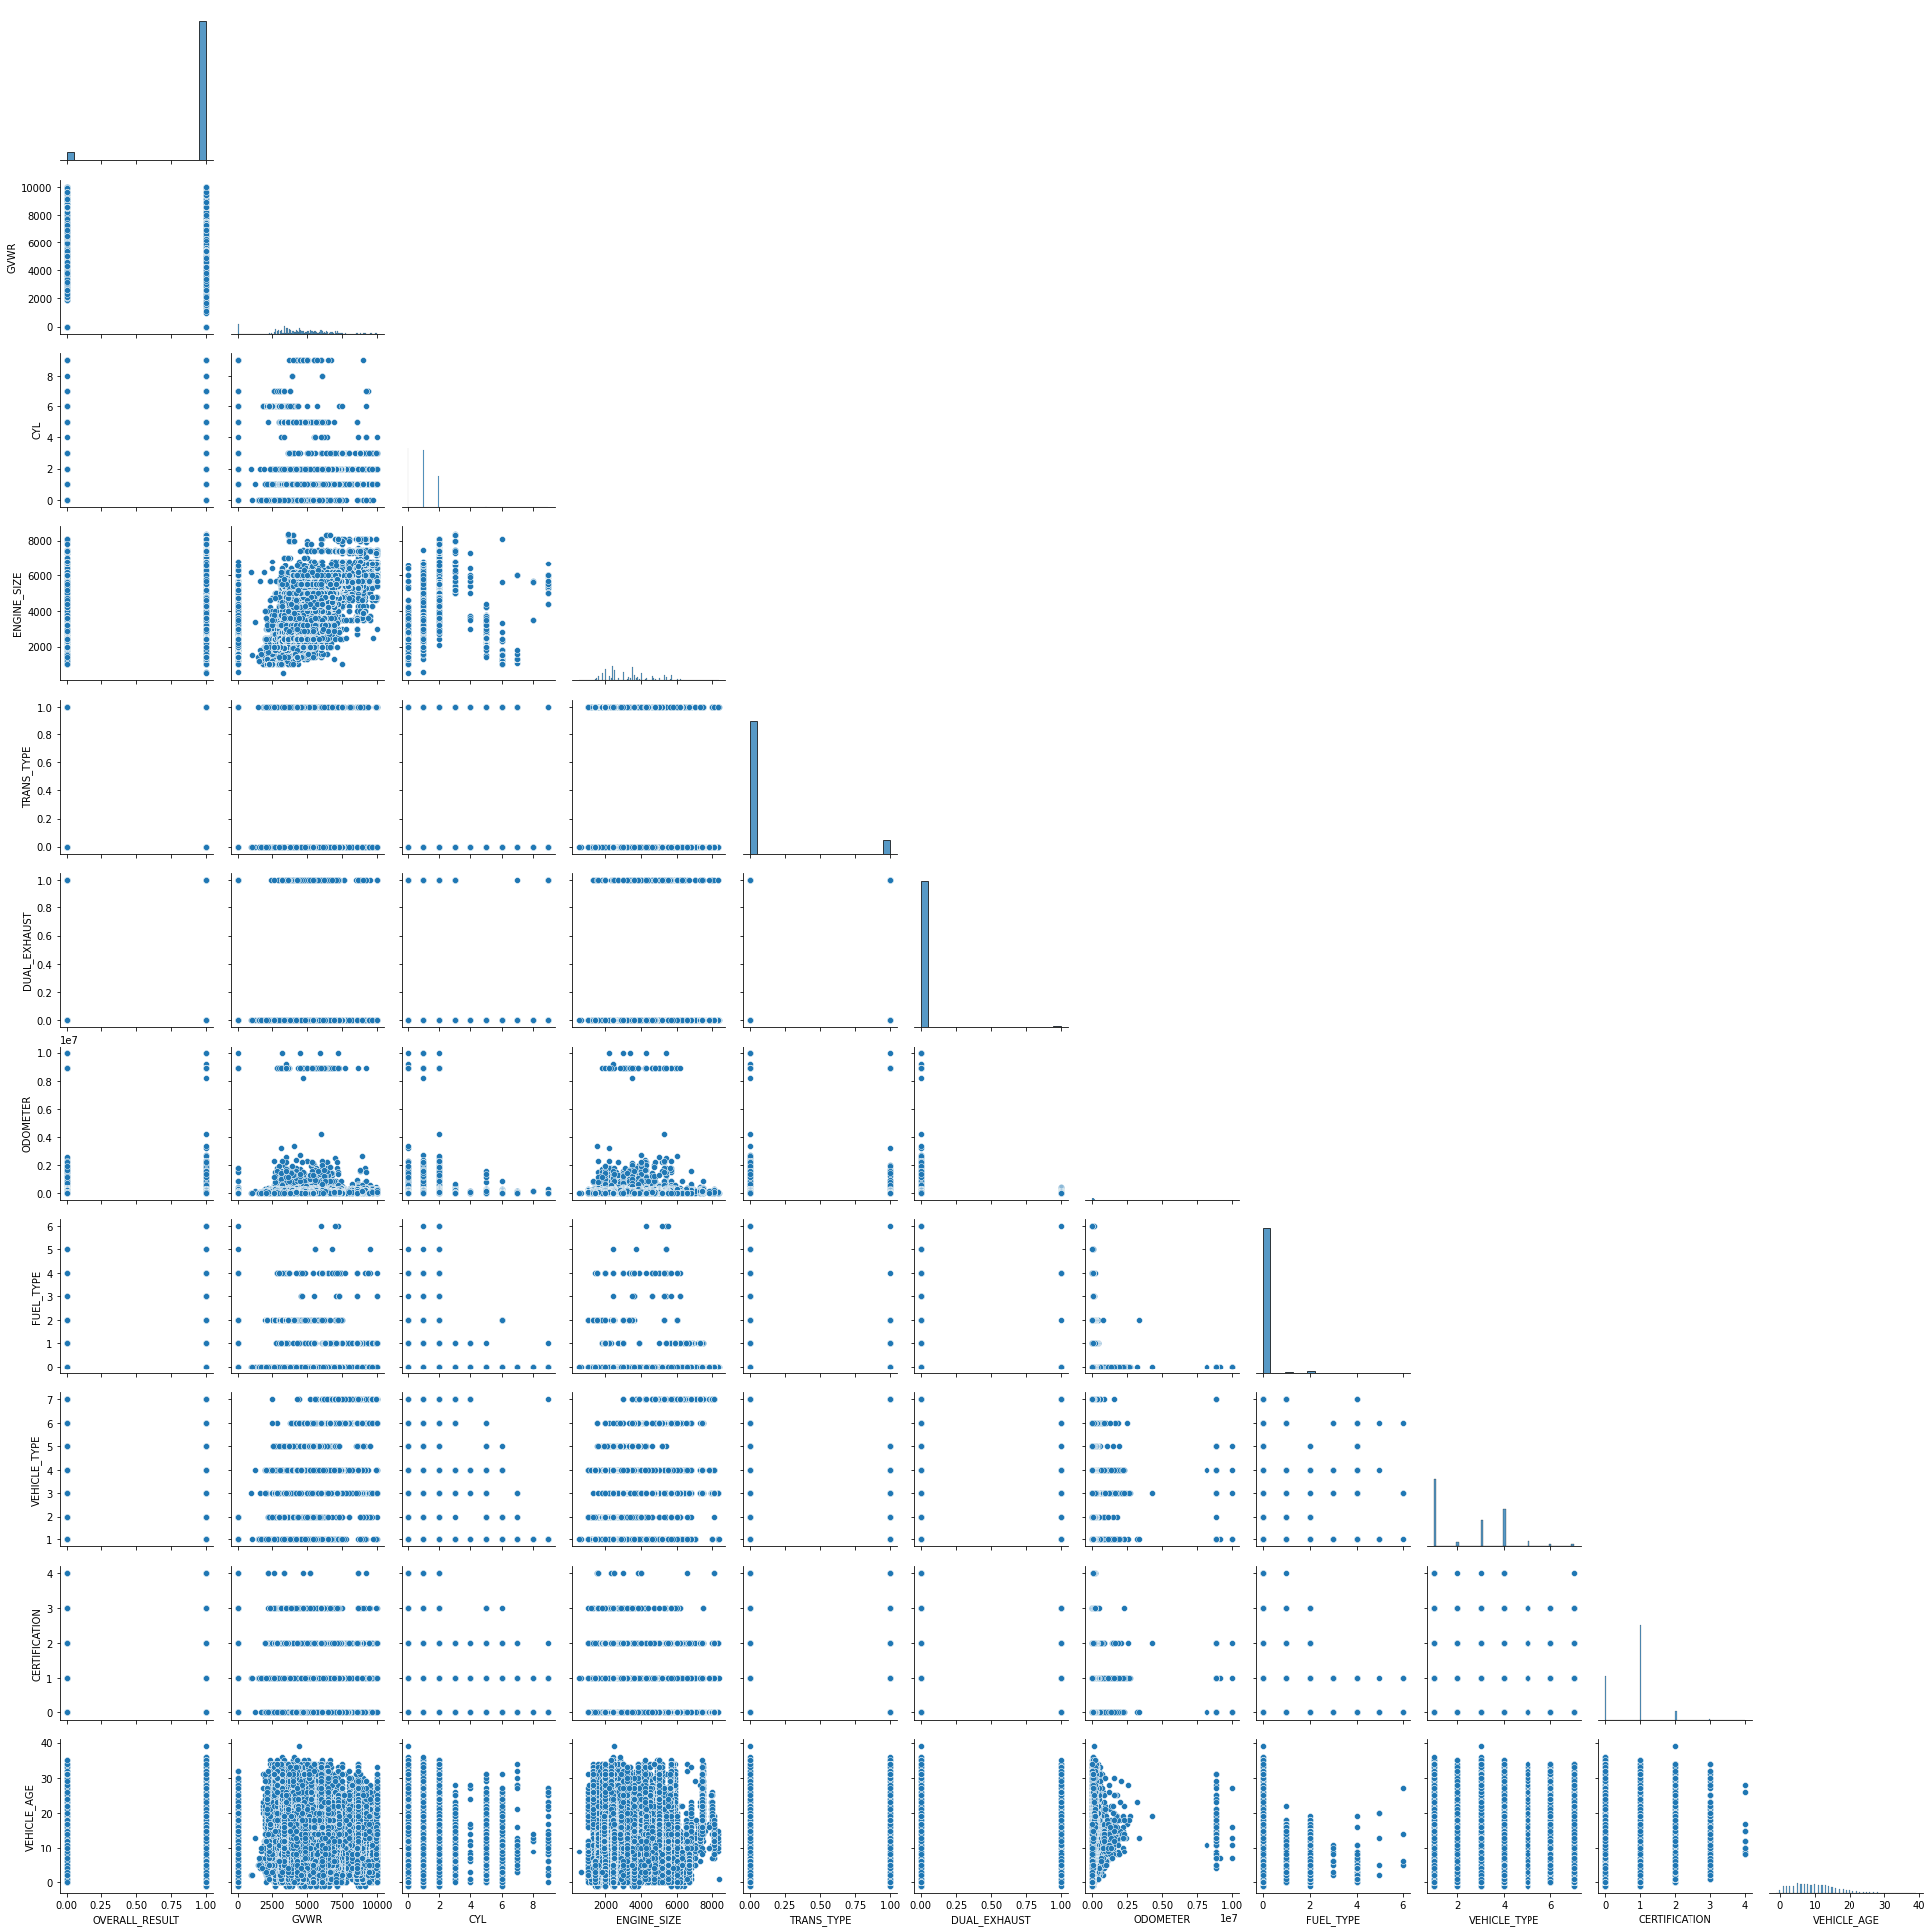

In [60]:
# select columns for pairplot
essential_cols = ['OVERALL_RESULT',  
                  'GVWR', 
                  'CYL', 
                  'ENGINE_SIZE', 
                  'TRANS_TYPE', 
                  'DUAL_EXHAUST', 
                  'ODOMETER',
                  'FUEL_TYPE', 
                  'VEHICLE_TYPE', 
                  'CERTIFICATION',
                  'VEHICLE_AGE']

# check for patterns
sns.pairplot(df[essential_cols], corner=True)

Age distribution of vehicles which PASSED in emission test


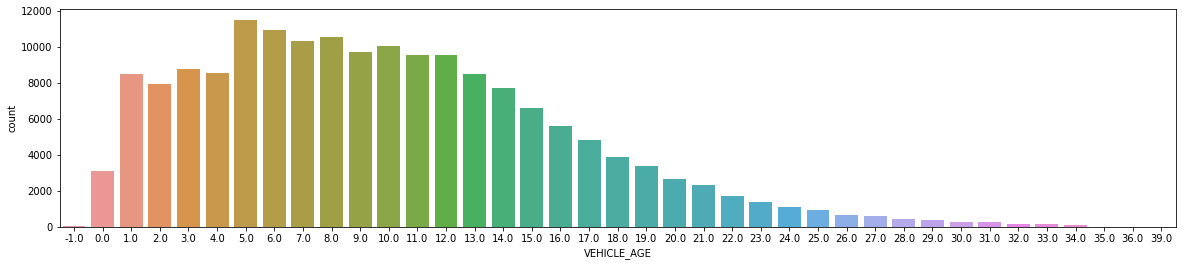

In [31]:
print("Age distribution of vehicles which PASSED in emission test")
plt.figure(figsize=(20,4))
sns.countplot(data=df[df.OVERALL_RESULT==1], x='VEHICLE_AGE');

Age distribution of vehicles which FAILED in emission test


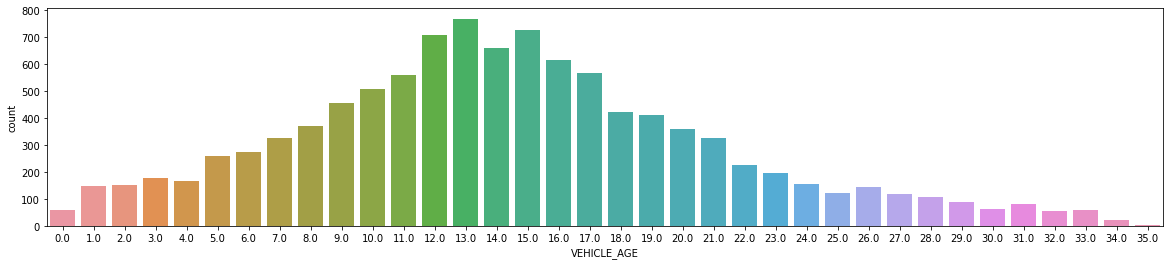

In [32]:
print("Age distribution of vehicles which FAILED in emission test")
plt.figure(figsize=(20,4))
sns.countplot(data=df[df.OVERALL_RESULT==0], x='VEHICLE_AGE');

In [37]:
# vehicles from a specific brand/model/year fails the test?
f = df.groupby('OVERALL_RESULT')['YEAR_MODEL'].apply(lambda x: x.value_counts())[0]
p = df.groupby('OVERALL_RESULT')['YEAR_MODEL'].apply(lambda x: x.value_counts())[1]
f[~f.index.isin(p.index)]

1987/regal              4
1989/c1500              4
1998/astro awd          3
2002/sl2                3
1993/trooper            3
                       ..
2001/siverado1500       1
1988/sierra             1
1990/cutlass calais     1
1992/k2500 suburban     1
2001/rodeo sport 2wd    1
Name: YEAR_MODEL, Length: 186, dtype: Int64

#### additionals

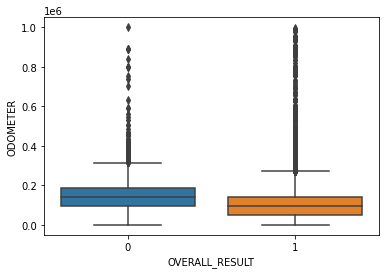

In [33]:
sns.boxplot(data=df[df.ODOMETER < 1000000], x='OVERALL_RESULT', y='ODOMETER');

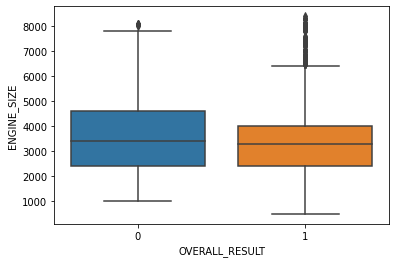

In [34]:
sns.boxplot(data=df, x='OVERALL_RESULT', y='ENGINE_SIZE');

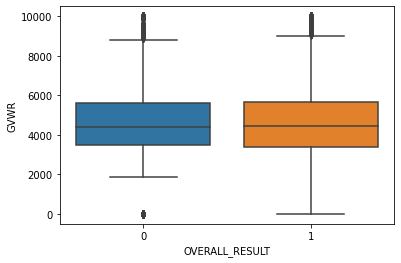

In [35]:
sns.boxplot(data=df, x='OVERALL_RESULT', y='GVWR');

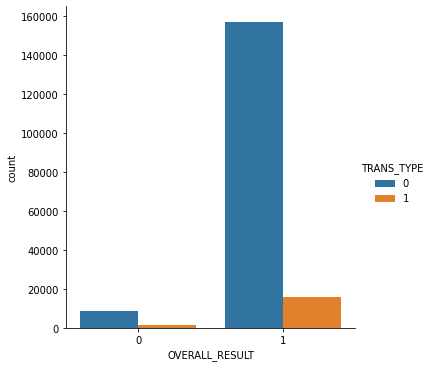

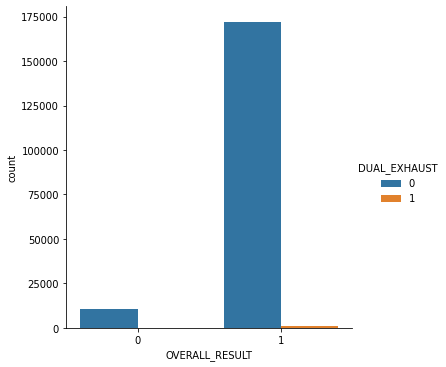

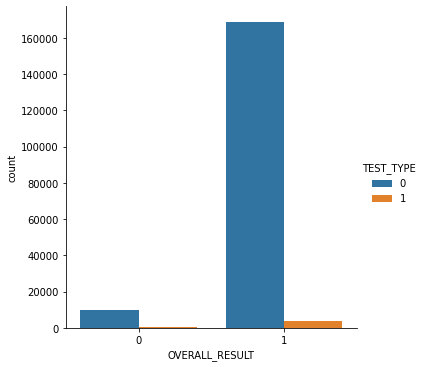

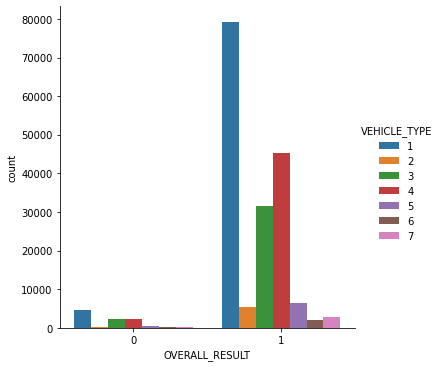

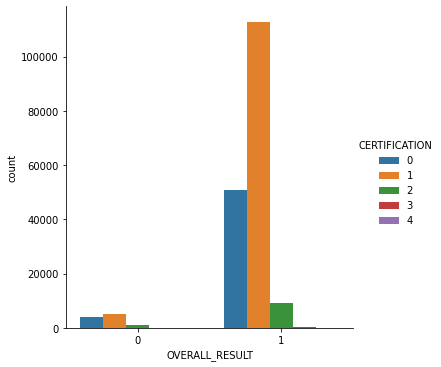

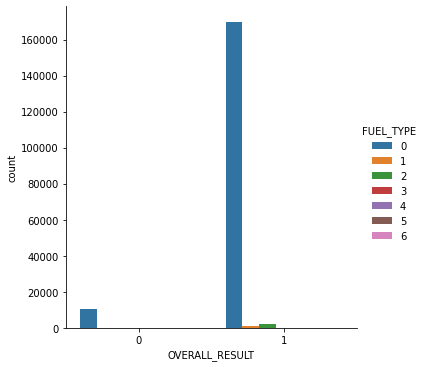

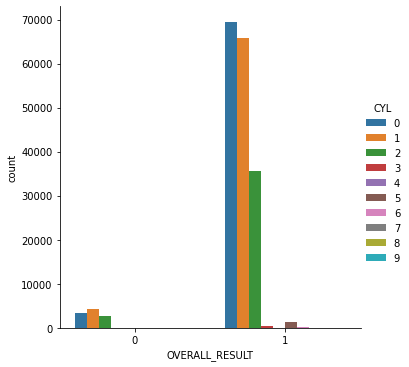

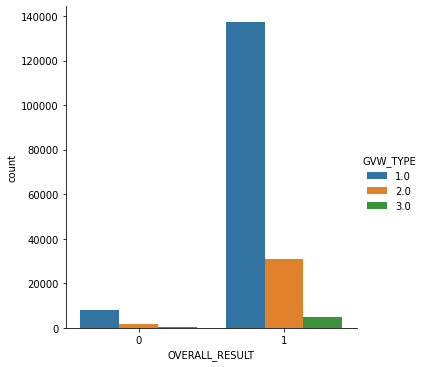

In [36]:
cols = ['TRANS_TYPE', 'DUAL_EXHAUST', 'TEST_TYPE', 'VEHICLE_TYPE', 'CERTIFICATION', 'FUEL_TYPE', 'CYL','GVW_TYPE']
for col in cols:
    sns.catplot(kind='count', data=df, x='OVERALL_RESULT', hue=col);

### vehicles with multiple records

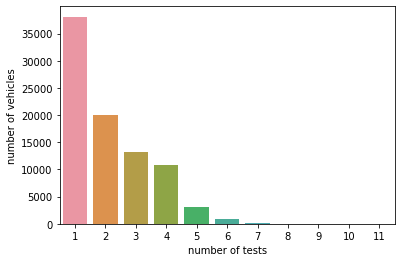

In [38]:
# how many vehicle were tested how many times
tmp = df.VIN.value_counts().sort_values()
ax = sns.countplot(x=tmp)
ax.set(ylabel='number of vehicles', xlabel='number of tests');

In [39]:
df.VIN.value_counts().value_counts()

1     38090
2     20086
3     13154
4     10760
5      3182
6       797
7       205
8        47
9        13
10        5
11        2
Name: VIN, dtype: Int64

In [40]:
# let's check a vehicle that was tested 10 times
df[df.VIN == df.VIN.value_counts().sort_values(ascending=False).index[5]]

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
2711408,0,3gcec14x97g252605,1.0,5500,2007,chevrolet,c1500,1,4300,0,0,129863,0,3,24.99,87114,0,0,0.0,2013-03-27 17:22:00,2013-03-27 17:24:00,6.0,chevrolet/c1500,2007/c1500
2715507,0,3gcec14x97g252605,1.0,5500,2007,chevrolet,c1500,1,4300,0,0,130073,0,3,24.99,87114,0,0,0.0,2013-04-01 16:26:00,2013-04-01 16:27:00,6.0,chevrolet/c1500,2007/c1500
2722299,1,3gcec14x97g252605,2.0,6100,2007,chevrolet,c1500,1,4300,0,0,130546,0,3,19.78,87110,0,0,0.0,2013-04-09 09:12:00,2013-04-09 09:16:00,6.0,chevrolet/c1500,2007/c1500
3251949,0,3gcec14x97g252605,2.0,6100,2007,chevrolet,c1500,1,4300,0,0,176254,0,3,24.99,87107,0,0,0.0,2015-03-23 16:41:00,2015-03-23 16:43:00,8.0,chevrolet/c1500,2007/c1500
3341723,1,3gcec14x97g252605,2.0,6100,2007,chevrolet,c1500,1,4300,0,0,181470,0,3,24.95,87110,0,0,0.0,2015-06-08 09:01:00,2015-06-08 09:03:00,8.0,chevrolet/c1500,2007/c1500
3619018,0,3gcec14x97g252605,2.0,6200,2007,chevrolet,c1500,1,4300,0,0,206691,0,3,21.00,87176,1,0,0.0,2016-06-14 16:29:00,2016-06-14 16:30:00,9.0,chevrolet/c1500,2007/c1500
3623744,1,3gcec14x97g252605,2.0,6100,2007,chevrolet,c1500,1,4300,0,0,206789,0,3,24.95,87110,0,0,0.0,2016-06-22 07:29:00,2016-06-22 07:30:00,9.0,chevrolet/c1500,2007/c1500
4191384,0,3gcec14x97g252605,2.0,6100,2007,chevrolet,silverado 1500,1,4300,0,0,248405,0,3,24.95,87110,0,0,NaN,2018-07-18 14:45:13,2018-07-18 14:49:06,11.0,chevrolet/silverado 1500,2007/silverado 1500
4284713,1,3gcec14x97g252605,2.0,6100,2007,chevrolet,silverado 1500,1,4300,0,0,250869,0,3,24.99,87113,0,0,NaN,2018-11-20 11:54:46,2018-11-20 12:00:39,11.0,chevrolet/silverado 1500,2007/silverado 1500


#### current records + last test records


In [41]:
# all the records where vehicles didn't receive test before
df1 = df.loc[df.groupby('VIN')['TEST_EDATE'].idxmin(),:]

# records whose vehicle has historical data
tmp = df.VIN.value_counts()
df2 = df[df.VIN.isin(tmp[tmp>1].index)]

print("Records where vehicles didn't receive test before", df1.shape)
print("Records where vehicles have historical data", df2.shape)

Records where vehicles didn't receive test before (86341, 24)
Records where vehicles have historical data (145366, 24)


In [48]:
# merge historical data once on VIN
df3 = df2.reset_index()
df4 = df2.drop(columns=['ZIP_CODE', 'EMISS_COST', 'MODEL_YEAR', 'MAKE', 'MODEL', 'MAKE_MODEL', 'YEAR_MODEL']).reset_index()
merge = pd.merge(df3, df4, how='left', on='VIN', suffixes=(None, '_1'))


# add a helper column
merge['DELTA'] = merge['TEST_EDATE']-merge['TEST_EDATE_1']

# keep the entries where TEST_DATE_1 is earlier than TEST_DATE
merge = merge[merge.DELTA > timedelta(days=0)]
merge.reset_index(drop=True, inplace=True)


# keep the rows whose DELTA is > 90, meaning vehicle's last check up was at least 90 days earlier than this time

# print(merge.shape)
# merge = merge[merge.DELTA > timedelta(days=90)]
# merge.reset_index(inplace=True)
# print(merge.shape)

# for each RecordID only keep most recent record as previous testing record
df_hist = merge.loc[merge.groupby('RecordID')['DELTA'].idxmin(), :]
df_hist.set_index('RecordID', inplace=True)

print("Number of records in historical dataframe", df_hist.shape[0])
print("Number of unique RecordIDs in historical dataframe", df_hist.index.nunique())

print("\nStatistic summary of time gaps between current and last tests\n")
df_hist.DELTA.describe()

Number of records in historical dataframe 97115
Number of unique RecordIDs in historical dataframe 97115

Statistic summary of time gaps between current and last tests



count                          97115
mean     632 days 18:47:54.309406368
std      357 days 17:37:34.162530284
min                  0 days 09:46:20
25%                389 days 21:19:39
50%                724 days 03:03:00
75%                757 days 22:12:55
max               2821 days 01:09:18
Name: DELTA, dtype: object

In [49]:
# stack df1 and df_hist
updated_df = pd.concat([df1, df_hist])
print("Shape of the new dataframe", updated_df.shape)

updated_df.sort_index().tail()

Shape of the new dataframe (183456, 42)


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL,RecordID_1,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,VEHICLE_AGE_1,DELTA
RecordID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4843546,1,2t3j1rfv5lc094886,1.0,4705,2020,toyota,rav4,0,2500,0,0,14070,0,4,25.00,87105,1,0,NaN,2020-12-31 16:28:39,2020-12-31 16:29:59,0.0,toyota/rav4,2020/rav4,4835394.0,1.0,1.0,4705.0,0.0,2500.0,0.0,0.0,13410.0,0.0,4.0,1.0,0.0,NaN,2020-12-17 10:59:01,2020-12-17 11:01:26,0.0,14 days 05:28:33
4843554,1,1g3nl52f74c169657,1.0,3250,2004,oldsmobile,alero,0,2200,0,0,120430,0,1,17.26,87123,1,0,NaN,2020-12-31 16:34:16,2020-12-31 16:38:05,16.0,oldsmobile/alero,2004/alero,3994340.0,1.0,1.0,3250.0,0.0,2200.0,0.0,0.0,84307.0,0.0,1.0,1.0,0.0,NaN,2017-10-25 11:09:37,2017-10-25 11:13:54,13.0,1163 days 05:24:11
4843592,1,kmhdu46d88u315460,1.0,3125,2008,hyundai,elantra,0,2000,1,0,153137,0,1,22.00,87102,1,0,NaN,2020-12-31 17:39:11,2020-12-31 17:40:36,12.0,hyundai/elantra,2008/elantra,4638360.0,1.0,1.0,3125.0,0.0,2000.0,1.0,0.0,144535.0,0.0,1.0,1.0,0.0,NaN,2020-03-07 12:53:20,2020-03-07 12:54:10,12.0,299 days 04:46:26
4844491,1,3gnek13t22g185380,2.0,7000,2002,chevrolet,avalanche 4wd,2,5300,0,0,0,0,3,20.00,87105,2,0,NaN,2020-12-29 14:19:52,2020-12-29 14:22:34,18.0,chevrolet/avalanche 4wd,2002/avalanche 4wd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
4844706,1,1hgcg56612a017292,1.0,4080,2002,honda,accord,0,2300,0,0,139330,0,1,40.00,87108,2,0,NaN,2020-12-31 16:13:15,2020-12-31 16:18:53,18.0,honda/accord,2002/accord,4049454.0,1.0,1.0,3250.0,0.0,2300.0,0.0,0.0,124072.0,0.0,1.0,2.0,0.0,NaN,2018-01-17 12:29:55,2018-01-17 12:32:27,16.0,1079 days 03:46:26


#### one entry for one vehicle



In [50]:
# keep most recent record for each vehicle

df1 = df.loc[df.groupby('VIN')['TEST_EDATE'].idxmax(),:]

# let's take the historical data out

df2 = df[~df.index.isin(df1.index)]

print("number records that don't belong to historical records:", df1.shape[0])
print('number of unique vehicles in df1:', df1.VIN.nunique())    
print('number records that belong to historical records:', df2.shape[0])

number records that don't belong to historical records: 86341
number of unique vehicles in df1: 86341
number records that belong to historical records: 97115


In [55]:
# let's peel the historical df2 like an onion into multiple dataframes according to timeline

older_records = [] # a list to collect dataframes

updated_df2 = df2.drop(columns=['ZIP_CODE', 'EMISS_COST', 'MODEL_YEAR', 'MAKE', 'MODEL', 'MAKE_MODEL', 'YEAR_MODEL']) # values in these columns don't change for a vehicle

for i in range(10):
    print(f'getting layer {i}')
    latest = updated_df2.loc[updated_df2.groupby('VIN')['TEST_EDATE'].idxmax(), :]
    older_records.append(latest.reset_index())
    tmp = updated_df2[~updated_df2.index.isin(latest.index)]
    updated_df2 = tmp.copy()

getting layer 0
getting layer 1
getting layer 2
getting layer 3
getting layer 4
getting layer 5
getting layer 6
getting layer 7
getting layer 8
getting layer 9


In [56]:
# merge the dataframes in older_records with df1

updated_df2 = df1
for index, record in enumerate(older_records):
    merged_df = pd.merge(updated_df2, record, how='left', on='VIN', suffixes=(None, '_'+str(index+1)))
    updated_df2 = merged_df.copy()  

print('The size of one-entry-one-vehicle dataframe:', updated_df2.shape)

# let's check out the vehicles that were tested for 11 times in last 7 years
updated_df2[~updated_df2.RecordID_10.isnull()]

The size of one-entry-one-vehicle dataframe: (86341, 194)


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VEHICLE_AGE,MAKE_MODEL,YEAR_MODEL,RecordID,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,VEHICLE_AGE_1,RecordID_2,OVERALL_RESULT_2,GVW_TYPE_2,GVWR_2,CYL_2,ENGINE_SIZE_2,TRANS_TYPE_2,DUAL_EXHAUST_2,ODOMETER_2,FUEL_TYPE_2,VEHICLE_TYPE_2,CERTIFICATION_2,TEST_TYPE_2,VID_TEST_TYPE_2,TEST_SDATE_2,TEST_EDATE_2,VEHICLE_AGE_2,RecordID_3,OVERALL_RESULT_3,GVW_TYPE_3,GVWR_3,CYL_3,ENGINE_SIZE_3,TRANS_TYPE_3,DUAL_EXHAUST_3,ODOMETER_3,FUEL_TYPE_3,VEHICLE_TYPE_3,CERTIFICATION_3,TEST_TYPE_3,VID_TEST_TYPE_3,TEST_SDATE_3,TEST_EDATE_3,VEHICLE_AGE_3,RecordID_4,OVERALL_RESULT_4,GVW_TYPE_4,GVWR_4,CYL_4,ENGINE_SIZE_4,TRANS_TYPE_4,DUAL_EXHAUST_4,ODOMETER_4,FUEL_TYPE_4,VEHICLE_TYPE_4,CERTIFICATION_4,TEST_TYPE_4,VID_TEST_TYPE_4,TEST_SDATE_4,TEST_EDATE_4,VEHICLE_AGE_4,RecordID_5,OVERALL_RESULT_5,GVW_TYPE_5,GVWR_5,CYL_5,ENGINE_SIZE_5,TRANS_TYPE_5,DUAL_EXHAUST_5,ODOMETER_5,FUEL_TYPE_5,VEHICLE_TYPE_5,CERTIFICATION_5,TEST_TYPE_5,VID_TEST_TYPE_5,TEST_SDATE_5,TEST_EDATE_5,VEHICLE_AGE_5,RecordID_6,OVERALL_RESULT_6,GVW_TYPE_6,GVWR_6,CYL_6,ENGINE_SIZE_6,TRANS_TYPE_6,DUAL_EXHAUST_6,ODOMETER_6,FUEL_TYPE_6,VEHICLE_TYPE_6,CERTIFICATION_6,TEST_TYPE_6,VID_TEST_TYPE_6,TEST_SDATE_6,TEST_EDATE_6,VEHICLE_AGE_6,RecordID_7,OVERALL_RESULT_7,GVW_TYPE_7,GVWR_7,CYL_7,ENGINE_SIZE_7,TRANS_TYPE_7,DUAL_EXHAUST_7,ODOMETER_7,FUEL_TYPE_7,VEHICLE_TYPE_7,CERTIFICATION_7,TEST_TYPE_7,VID_TEST_TYPE_7,TEST_SDATE_7,TEST_EDATE_7,VEHICLE_AGE_7,RecordID_8,OVERALL_RESULT_8,GVW_TYPE_8,GVWR_8,CYL_8,ENGINE_SIZE_8,TRANS_TYPE_8,DUAL_EXHAUST_8,ODOMETER_8,FUEL_TYPE_8,VEHICLE_TYPE_8,CERTIFICATION_8,TEST_TYPE_8,VID_TEST_TYPE_8,TEST_SDATE_8,TEST_EDATE_8,VEHICLE_AGE_8,RecordID_9,OVERALL_RESULT_9,GVW_TYPE_9,GVWR_9,CYL_9,ENGINE_SIZE_9,TRANS_TYPE_9,DUAL_EXHAUST_9,ODOMETER_9,FUEL_TYPE_9,VEHICLE_TYPE_9,CERTIFICATION_9,TEST_TYPE_9,VID_TEST_TYPE_9,TEST_SDATE_9,TEST_EDATE_9,VEHICLE_AGE_9,RecordID_10,OVERALL_RESULT_10,GVW_TYPE_10,GVWR_10,CYL_10,ENGINE_SIZE_10,TRANS_TYPE_10,DUAL_EXHAUST_10,ODOMETER_10,FUEL_TYPE_10,VEHICLE_TYPE_10,CERTIFICATION_10,TEST_TYPE_10,VID_TEST_TYPE_10,TEST_SDATE_10,TEST_EDATE_10,VEHICLE_AGE_10
69953,1,jm1na3535r0503494,1.0,2770,1994,mazda,miata,0,1800,1,0,147254,0,1,16.13,87123,0,0,NaN,2020-06-15 15:42:56,2020-06-15 15:50:01,26.0,mazda/miata,1994/miata,4615145.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,144900.0,0.0,1.0,1.0,0.0,NaN,2020-02-08 09:57:01,2020-02-08 10:02:59,26.0,4309672.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,137314.0,0.0,1.0,1.0,0.0,NaN,2018-12-29 11:13:44,2018-12-29 11:19:53,24.0,3732894.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,128221.0,0.0,1.0,1.0,0.0,0.0,2016-11-08 11:31:00,2016-11-08 11:36:00,22.0,3611495.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,127063.0,0.0,1.0,1.0,0.0,0.0,2016-06-03 16:41:00,2016-06-03 16:50:00,22.0,3605790.0,0.0,1.0,2625.0,0.0,1800.0,1.0,0.0,126950.0,0.0,1.0,1.0,1.0,1.0,2016-05-30 14:41:00,2016-05-30 14:50:00,22.0,3573675.0,0.0,1.0,2625.0,0.0,1800.0,1.0,0.0,126781.0,0.0,1.0,1.0,0.0,0.0,2016-04-18 15:39:00,2016-04-18 15:53:00,22.0,3334094.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,125431.0,0.0,1.0,1.0,1.0,1.0,2015-05-31 16:49:00,2015-05-31 16:59:00,21.0,3332944.0,0.0,1.0,2625.0,0.0,1800.0,1.0,0.0,125408.0,0.0,1.0,1.0,0.0,0.0,2015-05-29 15:19:00,2015-05-29 15:29:00,21.0,2784833.0,1.0,1.0,2625.0,0.0,1800.0,1.0,0.0,122541.0,0.0,1.0,1.0,1.0,1.0,2013-06-26 18:14:00,2013-06-26 18:20:00,19.0,2779499.0,0.0,1.0,2625.0,0.0,1800.0,1.0,0.0,122495.0,0.0,1.0,1.0,0.0,0.0,2013-06-19 16:38:00,2013-06-19 16:46:00,19.0
78108,1,km8jn12d86u437446,1.0,4652,2006,hyundai,tucson,1,2700,0,0,182874,0,4,21.00,87121,1,0,NaN,2020-11-06 14:08:40,2020-11-06 14:09:52,14.0,hyundai/tucson,2006/tucson,4810353.0,0.0,1.0,4652.0,1.0,2700.0,0.0,0.0,182778.0,0.0,4.0,1.0,1.0,NaN

### further exploration


# emission tests




In [ ]:
# columns related to tests started with E_
etest_cols = ['RECORD_NUM', 'VIR_CERT_NUMBER', 'STATION_NUM', 'ANALYZER_NUM', 'INSPECTOR_NUM',
              'ESC', 'E_TEST_SEQUENCE', 'E_PRECOND_PROCEDURE', 'E_HIGH_DCF', 'E_HIGH_RPM', 
              'E_HIGH_CO2', 'E_HIGH_O2', 'E_HIGH_HC', 'E_HIGH_HC_DCF', 'E_HIGH_HC_LIMIT', 'E_HIGH_CO', 
              'E_HIGH_CO_DCF', 'E_HIGH_CO_LIMIT', 'E_IDLE_DCF', 'E_IDLE_RPM', 'E_IDLE_CO2', 'E_IDLE_O2', 
              'E_IDLE_HC', 'E_IDLE_HC_DCF', 'E_IDLE_HC_LIMIT', 'E_IDLE_CO', 'E_IDLE_CO_DCF', 'E_IDLE_CO_LIMIT', 
              'E_HIGH_DCF_2', 'E_HIGH_RPM_2', 'E_HIGH_CO2_2', 'E_HIGH_O2_2', 'E_HIGH_HC_2', 'E_HIGH_HC_DCF_2', 
              'E_HIGH_CO_2', 'E_HIGH_CO_DCF_2', 'E_IDLE_DCF_2', 'E_IDLE_RPM_2', 'E_IDLE_CO2_2', 'E_IDLE_O2_2', 
              'E_IDLE_HC_2', 'E_IDLE_HC_DCF_2', 'E_IDLE_CO_2', 'E_IDLE_CO_DCF_2', 'E_RESULT_STRING']

# visual tests

In [ ]:
# columns related to visual inspectation
vtest_cols = ['RecordID',
              'V_SMOKE1', 'V_SMOKE2', 
               'V_GASCAP', 'V_CAT', 
               'V_RESULT', 
               'KOEO_RESULT', 'KOER_RESULT']

# OBDII tests

In [ ]:
# columns related to OBDII tests
otest_cols = ['RecordID',
              'OBD_RDY_MISFIRE', 'OBD_RDY_FUEL', 'OBD_RDY_COMPONENT', 'OBD_RDY_CAT', 'OBD_RDY_CAT_HEATED', 
               'OBD_RDY_EVAP', 'OBD_RDY_SEC_AIR', 'OBD_RDY_AIR_COND', 'OBD_RDY_O2_SENSOR', 'OBD_RDY_O2_HEATER', 
               'OBD_RDY_EGR', 'OBD_RDY_RESULT', 'OBD_PID', 'OBD_PCM_ID', 'OBD_VIN', 'OBD_FLT_CODES', 'OBD_FLT_RESULT', 
               'OBD_MIL_STATUS', 'OBD_RESULT', 'OBDII_AFFECT_OVERALL',
               'ONLINE_STATUS', 'OFFLINE_REASON_CODE', 'ABORT_CODE', 'SOFTWARE_VERSION', 'INSP_COMMENTS']

# repairs

In [ ]:
# columns related to repairments
repair_cols = ['RecordID',
               'R_TOTAL_COST', 
                'R_EGR', 'R_ELECTRICAL', 'R_EVAP_CONTROL', 'R_EXHAUST', 
                'R_IGNITION', 'R_INTAKE', 'R_ENGINE', 'R_PCV', 'R_OTHER', 
                'SentToWW', 'ABORT_CODE_OTHER_DESC', 
                'E_HIGH_CO_RESULT', 'E_HIGH_HC_RESULT', 
                'E_IDLE_CO_RESULT', 'E_IDLE_HC_RESULT', 
                'MECHANIC_LAST_NAME', 'MECHANIC_FIRST_NAME', 'MECHANIC_MIDDLE_INIT', 
                'ENGINE_SIZE_ORIG', 'FAILED_IDLE_RPM', 'SENTTOVID', 
                'Station_License_Number', 'Analyzer_Number', 
                'Insert_DateTime']

# feature selection


https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2
https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b